# Component 3: Preprocessing & Data Pipelines

Define preprocessing variants, augmentation, and build tf.data pipelines

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load manifests
train_df = pd.read_csv('../outputs/train_manifest.csv')
val_df = pd.read_csv('../outputs/val_manifest.csv')
test_df = pd.read_csv('../outputs/test_manifest.csv')

print(f'Train: {len(train_df)} images')
print(f'Val:   {len(val_df)} images')
print(f'Test:  {len(test_df)} images')
print(f'Classes: {len(train_df["class_label"].unique())}')

Train: 8220 images
Val:   1761 images
Test:  1762 images
Classes: 4


## 3.1 Preprocessing Functions

In [2]:
def preprocess_resize_rescale(filepath, label):
    """Simple resize and rescale to [0,1]."""
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

def preprocess_resnet(filepath, label):
    """ResNet50-specific preprocessing."""
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img, label

def preprocess_efficientnet(filepath, label):
    """EfficientNet-specific preprocessing."""
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img, label

def preprocess_densenet(filepath, label):
    """DenseNet-specific preprocessing."""
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.densenet.preprocess_input(img)
    return img, label

print("✓ Preprocessing functions defined")

✓ Preprocessing functions defined


## 3.2 Data Augmentation

In [3]:
# Define augmentation pipeline
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
], name='augmentation')

print("✓ Augmentation pipeline created")
print("  - RandomFlip (horizontal)")
print("  - RandomRotation (±20%)")
print("  - RandomZoom (±20%)")
print("  - RandomContrast (±20%)")

✓ Augmentation pipeline created
  - RandomFlip (horizontal)
  - RandomRotation (±20%)
  - RandomZoom (±20%)
  - RandomContrast (±20%)


2026-01-28 23:38:39.208394: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2026-01-28 23:38:39.208469: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-28 23:38:39.208479: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-01-28 23:38:39.208718: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-28 23:38:39.208736: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 3.3 Build tf.data Pipelines

In [4]:
def build_dataset(dataframe, preprocess_fn, augment=False, shuffle=True, batch_size=BATCH_SIZE):
    """Build optimized tf.data pipeline."""
    filepaths = dataframe['filepath'].values
    labels = dataframe['class_label'].values
    
    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    
    # Preprocessing
    ds = ds.map(preprocess_fn, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Cache before augmentation
    ds = ds.cache()
    
    # Augmentation (only for training)
    if augment:
        ds = ds.map(lambda x, y: (augmentation(x, training=True), y), 
                   num_parallel_calls=tf.data.AUTOTUNE)
    
    # Shuffle
    if shuffle:
        ds = ds.shuffle(buffer_size=1000, seed=SEED)
    
    # Batch and prefetch
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

print("✓ Dataset building function defined")

✓ Dataset building function defined


## 3.4 Create Datasets (Basic Preprocessing)

In [5]:
# Build datasets with simple resize+rescale
train_ds = build_dataset(train_df, preprocess_resize_rescale, augment=True, shuffle=True)
val_ds = build_dataset(val_df, preprocess_resize_rescale, augment=False, shuffle=False)
test_ds = build_dataset(test_df, preprocess_resize_rescale, augment=False, shuffle=False)

print("✓ Datasets created")
print(f"  Train: {len(train_df)} images, {len(train_ds)} batches")
print(f"  Val:   {len(val_df)} images, {len(val_ds)} batches")
print(f"  Test:  {len(test_df)} images, {len(test_ds)} batches")

✓ Datasets created
  Train: 8220 images, 257 batches
  Val:   1761 images, 56 batches
  Test:  1762 images, 56 batches


## 3.5 Test Pipeline

Testing pipeline with a sample batch...


2026-01-28 23:38:47.395891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2026-01-28 23:38:48.486694: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0259213].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0288919].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0120281].
Clippin


Batch shape: (32, 224, 224, 3)
Labels shape: (32,)
Image dtype: <dtype: 'float32'>
Image range: [0.000, 1.089]
Labels: [3 3 2 3 3 0 3 3 3 3 0 3 0 3 2 3 3 3 3 0 3 3 1 0 3 0 3 3 3 1 0 3]


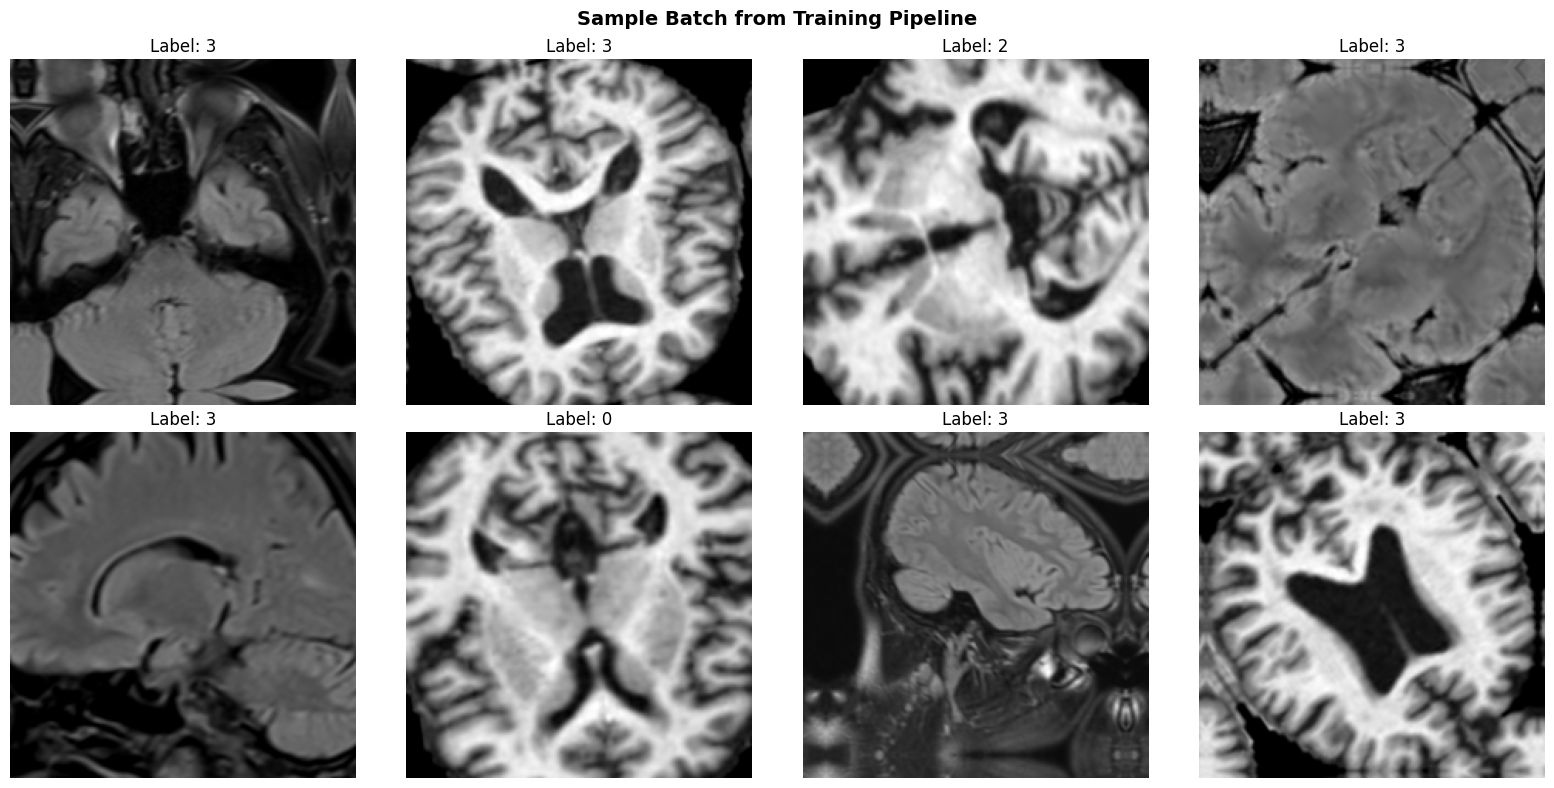


✅ PREPROCESSING COMPLETE

Datasets are ready for model training!

Available preprocessing functions:
  - preprocess_resize_rescale (for Baseline CNN)
  - preprocess_resnet (for ResNet50)
  - preprocess_efficientnet (for EfficientNetB0)
  - preprocess_densenet (for DenseNet121)


2026-01-28 23:38:48.858573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
# Test the pipeline
print("Testing pipeline with a sample batch...")
for images, labels in train_ds.take(1):
    print(f"\nBatch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Image dtype: {images.dtype}")
    print(f"Image range: [{images.numpy().min():.3f}, {images.numpy().max():.3f}]")
    print(f"Labels: {labels.numpy()}")
    
    # Visualize a few samples
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    for i, ax in enumerate(axes.flatten()):
        if i < images.shape[0]:
            ax.imshow(images[i].numpy())
            ax.set_title(f'Label: {labels[i].numpy()}')
            ax.axis('off')
    plt.suptitle('Sample Batch from Training Pipeline', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("✅ PREPROCESSING COMPLETE")
print("="*60)
print("\nDatasets are ready for model training!")
print("\nAvailable preprocessing functions:")
print("  - preprocess_resize_rescale (for Baseline CNN)")
print("  - preprocess_resnet (for ResNet50)")
print("  - preprocess_efficientnet (for EfficientNetB0)")
print("  - preprocess_densenet (for DenseNet121)")